# Energy Maneuverability Diagrams

Code to enable the easy generation of an EM diagram. 

Example of a Matlab based EM diagram generator.

![Matlab EM Diagram Generator](images/F-15C%20Matlab%20EM%20Diagram.png)

Example of an EM diagram for an F-16.

![F-16 EM Example](images/F16%20EM%20Example.jpg)

General EM diagram traits.

![General EM Diagram](images/General%20EM.jpg)


### Basic Turn Performance

Assuming a level turn.

$lateral \: g = \sqrt{n_z^2 - 1}$

$a = \frac{V^2}{R}$

$R = \frac{V^2} {\sqrt{n_z^2 -1 }}$

$\omega = \frac{\sqrt{n_z^2 -1}} {V}$

### Specific Excess Energy

$ P_S = V(\frac{T - D}{W}) $

$ P_S = Specific \: Excess \: Energy $

$ V = Speed $

$ T = Thrust $

$ D = Drag $

$ W = Weight $

### Calculating Lines of Constant $P_s$

For a given Ps, e.g. 200ft/s run through the speed range and for each speed use the thrust model to calculate thrust based on altitude and Mach. Then solve for drag.

$ D = T - P_s \frac{W}{V} $

Once the drag has been solved for we then need to solve for $C_l$.

$ C_D = C_{D0} + C_{D_i} $

$ C_{D_i} = \frac{C_l^2}{\pi e AR} $

TODO - need to take drag increase due to Mach into account. Note the distinct kink in the $P_S$ curves around Mach 0.9 for the F-16 EM diagram example.

![Drag Divergence Mach Number](images/Drag%20Divergence%20Mach%20Number.png)

Given the calculated $C_l$, weight, altitude and speed a load factor can be calculated, which is then used to calculate a turn rate $\omega$. Providing a $(speed, \omega)$ point for the specified line of constant $P_s$  on the graph.



### Thrust Model

From JSBSim for the F100-PW-229 engine model file.

`
<turbine_engine name="F100">
  <milthrust>   17800.0 </milthrust>
  <maxthrust>   29000.0 </maxthrust>
`

`
  <function name="AugThrust">
   <table>
    <independentVar lookup="row">velocities/mach</independentVar>
    <independentVar lookup="column">atmosphere/density-altitude</independentVar>
    <tableData>
           -10000       0   10000   20000   30000   40000   50000   60000
     0.0    1.1816  1.0000  0.8184  0.6627  0.5280  0.3756  0.2327  0.0
     0.2    1.1308  0.9599  0.7890  0.6406  0.5116  0.3645  0.2258  0.0
     0.4    1.1150  0.9474  0.7798  0.6340  0.5070  0.3615  0.2240  0.0
     0.6    1.1284  0.9589  0.7894  0.6420  0.5134  0.3661  0.2268  0.0
     0.8    1.1707  0.9942  0.8177  0.6647  0.5309  0.3784  0.2345  0.0
     1.0    1.2411  1.0529  0.8648  0.7017  0.5596  0.3983  0.2467  0.0
     1.2    1.3287  1.1254  0.9221  0.7462  0.5936  0.4219  0.2614  0.0
     1.4    1.4365  1.2149  0.9933  0.8021  0.6360  0.4509  0.2794  0.0
     1.6    1.5711  1.3260  1.0809  0.8700  0.6874  0.4860  0.3011  0.0
     1.8    1.7301  1.4579  1.1857  0.9512  0.7495  0.5289  0.3277  0.0
     2.0    1.8314  1.5700  1.3086  1.0474  0.8216  0.5786  0.3585  0.0
     2.2    1.9700  1.6900  1.4100  1.2400  0.9100  0.6359  0.3940  0.0
     2.4    2.0700  1.8000  1.5300  1.3400  1.0000  0.7200  0.4600  0.0
     2.6    2.2000  1.9200  1.6400  1.4400  1.1000  0.8000  0.5200  0.0
    </tableData>
   </table>
  </function>
`

In [1]:
%matplotlib notebook

import math
import numpy as np
import matplotlib.pyplot as plt
from Atmosphere import ISAtmosphere
from Conversions import *

In [2]:
class F15:
    def __init__(self):
        self.CLMax = 1.213096
        self.S = 608
        self.Maxg = 9
        self.Vne = 800

    def Drag(self, density, tas, mach):
        return 0

    def Thrust(self, altitude, density, tas, mach):
        return 46000

In [3]:
g = 32.17405

font = {'family': 'Times New Roman',
        'color':  'darkred',
        'weight': 'normal',
        'size': 10,
        }

In [4]:
# Lateral g given a load factor and assuming level turn
def lateral_g(load_factor):
    return math.sqrt(load_factor**2 - 1)

In [5]:
def speed_and_turnrate(nlf, radius):
    lateralg = lateral_g(nlf)
    speed = math.sqrt(lateralg*g*radius)
    turnrate = 360 / ((2 * math.pi * radius) / speed)
    return (speed, turnrate)

In [6]:
def plot_turn_radius_lines(ax, radii, gs, altitude):
    for radius in radii:
        speeds = []
        turnrates = []
        for nlf in gs:
            (speed, turnrate) = speed_and_turnrate(nlf, radius)
            speeds.append(fpsTokt(TAStoCAS(speed, altitude)))
            turnrates.append(turnrate)
        ax.plot(speeds, turnrates, color='black', linestyle='--')
        ax.text(speeds[-1], turnrates[-1], '  {0} ft'.format(radius), fontdict=font, horizontalalignment='left', verticalalignment='bottom')

In [7]:
def plot_g_lines(ax, gs, radii, altitude):
    for nlf in gs:
        speeds = []
        turnrates = []
        for radius in radii:
            (speed, turnrate) = speed_and_turnrate(nlf, radius)
            speeds.append(fpsTokt(TAStoCAS(speed, altitude)))
            turnrates.append(turnrate)
        ax.plot(speeds, turnrates, color='black')
        ax.text(speeds[0], turnrates[0], 'n={0}  '.format(nlf), fontdict=font, horizontalalignment='right', verticalalignment='center')

In [8]:
def render_background(ax, altitude, g_values, radius_values):
    ax.set_xlim(xmin=0, xmax=900)
    ax.set_ylim(ymin=0, ymax=35)

    plot_turn_radius_lines(ax, radius_values, g_values, altitude)
    plot_g_lines(ax, g_values, range(min(radius_values), max(radius_values) + 100, 100), altitude)

    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.arange(xmin, xmax, 100))

    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='0.65', linestyle='--')
    ax.grid(b=True, which='major', color='0.65', linestyle='-')

    ax.set_ylabel('Turn Rate (deg/s)')
    ax.set_xlabel('Calibrated Airspeed (kt)')

    # Add Mach x-axis, CAS to Mach isn't linear
    (CASMin, CASMax) = ax.get_xlim()
    MachMin = CAStoMach(ktTofps(CASMin), altitude)
    MachMax = CAStoMach(ktTofps(CASMax), altitude)

    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 46))
    ax2.set_xlabel('Mach Number')

    ax2.set_xlim(CASMin, CASMax)
    mach_ticks = []
    mach_labels = []
    for mach in np.arange(MachMin, MachMax, 0.2):
        cas = fpsTokt(MachtoCAS(mach, altitude))
        m = CAStoMach(ktTofps(cas), altitude)
        mach_ticks.append(cas)
        mach_labels.append('{0:.1f}'.format(mach))
    ax2.xaxis.set_ticks(mach_ticks)
    ax2.xaxis.set_ticklabels(mach_labels)

In [9]:
def render_manuever_envelope(ax, aircraft, altitude, weight):
    # Calculate corner speed
    corner_speed_tas = math.sqrt((2 * aircraft.Maxg * weight) / (ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S))
    corner_speed_cas = TAStoCAS(corner_speed_tas, altitude)
    corner_speed_cas_kt = fpsTokt(corner_speed_cas)

    # 
    intervals = int((aircraft.Vne - corner_speed_cas_kt) / 10 + 1)
    airspeeds = np.linspace(corner_speed_cas_kt, aircraft.Vne, intervals)

    turn_rates = []
    for airspeed in airspeeds:
        # TODO Check this formula
        turn_rate = g*math.sqrt(aircraft.Maxg**2 - 1)/CAStoTAS(ktTofps(airspeed), altitude)
        turn_rates.append(math.degrees(turn_rate))

    # Drop down to x-axis at VNE
    airspeeds = np.append(airspeeds, aircraft.Vne)
    turn_rates.append(0)

    ax.plot(airspeeds, turn_rates, color='red', linewidth=3.0)

    # Accelerated stall side
    one_g_stall_speed_tas = math.sqrt( (2 * weight) / (ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S) )
    one_g_stall_speed_cas = TAStoCAS(one_g_stall_speed_tas, altitude)
    one_g_stall_speed_cas_kt = fpsTokt(one_g_stall_speed_cas)

    #
    intervals = int((corner_speed_cas_kt - one_g_stall_speed_cas_kt) / 10 + 1)
    airspeeds = np.linspace(one_g_stall_speed_cas_kt + 1, corner_speed_cas_kt, intervals)

    turn_rates = []
    for airspeed in airspeeds:
        tas = CAStoTAS(ktTofps(airspeed), altitude)
        nlf = (0.5 * ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S * tas * tas) / weight
        turn_rate = g*math.sqrt(nlf**2 - 1)/tas
        turn_rates.append(math.degrees(turn_rate))

    ax.plot(airspeeds, turn_rates, color='red', linewidth=3.0)

In [18]:
def render(aircraft, altitude, weight, g_values, radius_values):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    render_background(ax, altitude, g_values, radius_values)

    render_manuever_envelope(ax, aircraft, altitude, weight)

    # HACK for now, render_manuever_envelope resets xlim to (75, 825)
    ax.set_xlim(0, 900)

    plt.show()

<IPython.core.display.Javascript object>


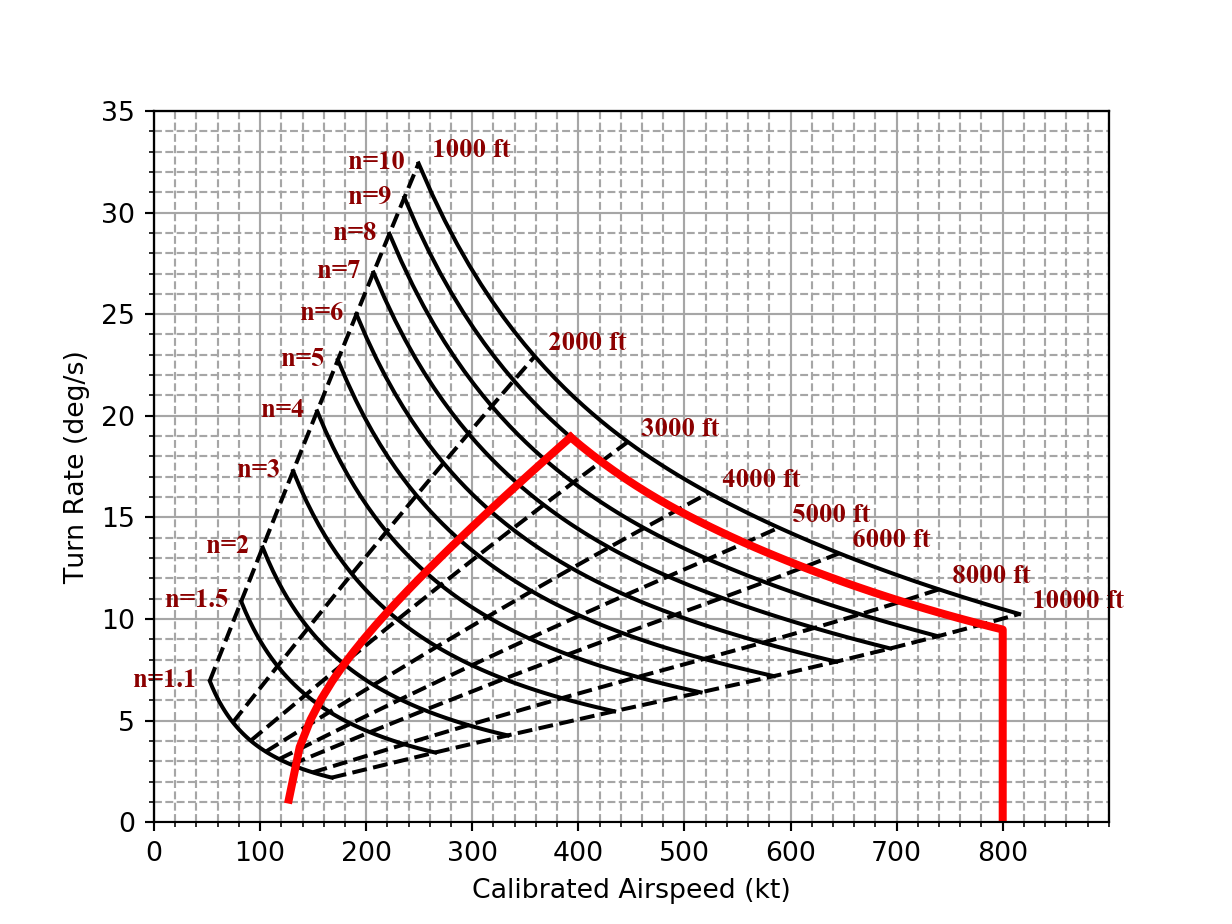

In [19]:
aircraft = F15()
altitude = 20000
weight = 39300
g_values = [1.1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]
radius_values = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000]

render(aircraft, altitude, weight, g_values, radius_values)